In [19]:
import pandas as pd
import utils
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics.regression import MeanSquaredError,R2Score
from torchinfo import summary
from sklearn.preprocessing import StandardScaler

In [20]:
featureDF=pd.read_csv('feature.csv')
targetDF=pd.read_csv('target.csv')

In [21]:
featureDF.shape,targetDF.shape

((153290, 5), (153290, 5))

In [22]:
featureDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153290 entries, 0 to 153289
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   일시          153290 non-null  object 
 1   최저기온(°C)    153290 non-null  float64
 2   최고기온(°C)    153290 non-null  float64
 3   일강수량(mm)    153290 non-null  float64
 4   평균 상대습도(%)  153290 non-null  float64
dtypes: float64(4), object(1)
memory usage: 5.8+ MB


In [23]:
featureDF=featureDF.drop(columns=['일시'])
featureDF.head()

,최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%)
0,15.3,23.6,0.0,68.0
1,13.7,23.9,0.0,64.9
2,9.6,22.4,0.0,78.0
3,12.0,21.3,0.0,92.8
4,11.2,22.9,0.1,89.4


In [24]:
#targetDF=targetDF.drop(columns=['일시','평균 상대습도(%)','일강수량(mm)'])
targetDF=targetDF[['일강수량(mm)']]
targetDF.head()

,일강수량(mm)
0,0.0
1,0.0
2,0.0
3,0.1
4,13.0


## 데이터 셋 분리 후 텐서화

In [25]:
SS=utils.SeperateSet(featureDF,targetDF)
X_train,X_val,X_test,y_train,y_val,y_test=SS.run()

In [26]:
print(f'X_train : {X_train.shape} X_val :{X_val.shape} X_test:{X_test.shape}')
print(f'y_train : {y_train.shape} y_val :{y_val.shape} y_test:{y_test.shape}')

X_train : (98105, 4) X_val :(24527, 4) X_test:(30658, 4)
y_train : (98105, 1) y_val :(24527, 1) y_test:(30658, 1)


In [27]:
# scaler=StandardScaler()
# scaler.fit(X_train)
# X_train=pd.DataFrame(scaler.transform(X_train))
# X_val=pd.DataFrame(scaler.transform(X_val))
# X_test=pd.DataFrame(scaler.transform(X_test))


In [28]:
trainDS=utils.MyDataSet(X_train,y_train)
valDS=utils.MyDataSet(X_val,y_val)
testDS=utils.MyDataSet(X_test,y_test)

In [29]:
trainDL=DataLoader(trainDS,batch_size=3000)
valDL=DataLoader(valDS,batch_size=len(valDS))

## 모델로딩

In [30]:
model=utils.DynamicsModel(featureDF.shape[1],targetDF.shape[1],nums=[8000])
optimizer=optim.Adam(model.parameters(),lr=2)

In [31]:
summary(model,input_size=X_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DynamicsModel                            [98105, 1]                --
├─Linear: 1-1                            [98105, 8000]             40,000
├─Linear: 1-2                            [98105, 1]                8,001
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
Total mult-adds (G): 4.71
Input size (MB): 1.57
Forward/backward pass size (MB): 6279.50
Params size (MB): 0.19
Estimated Total Size (MB): 6281.27

In [32]:
# 스케쥴러
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,patience=10,factor=0.90)

In [33]:
lossf=MeanSquaredError()
scoref=R2Score(num_outputs=targetDF.shape[1])

In [34]:
EPOCH=1000
trainmodel=utils.Train_val(trainDL,valDL,model,optimizer,lossf,scoref)
History=trainmodel.train(EPOCH,scheduler,modelnum='rain1')

[1/1000]
train loss 47359192844.66019, train score -315750539.3310944
val loss 1267607.125, val score -8642.076171875
scheduler.num_bad_epochs 0/10
[2/1000]
train loss 399706.4941258286, train score -2761.239038265113
val loss 68810.6171875, val score -468.1795959472656
scheduler.num_bad_epochs 0/10
[3/1000]
train loss 22442.30707619407, train score -158.1305108720606
val loss 10635.99609375, val score -71.52066802978516
scheduler.num_bad_epochs 0/10
[4/1000]
train loss 7048.089461817886, train score -49.43734682690013
val loss 3853.5576171875, val score -25.27516746520996
scheduler.num_bad_epochs 0/10
[5/1000]
train loss 3608.9068723736386, train score -25.025937781189427
val loss 1573.53955078125, val score -9.729050636291504
scheduler.num_bad_epochs 0/10
[6/1000]
train loss 2078.7531058571553, train score -14.008942138064992
val loss 833.2719116210938, val score -4.681596279144287
scheduler.num_bad_epochs 0/10
[7/1000]
train loss 1292.0434801506274, train score -8.326760443774136
va

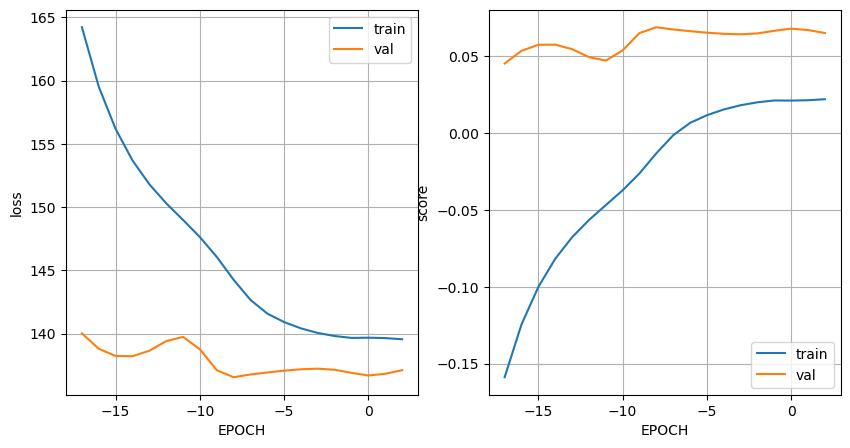

In [35]:
plothistoy=utils.Plot_History(History)
plothistoy.draw(num=20)

In [36]:
testDL=DataLoader(testDS,batch_size=X_test.shape[0])
for feature,target in testDL:
    test_y=model(feature)
    loss=lossf(test_y,target)
    score=scoref(test_y,target)
    print(f'test loss {loss}, test score {score}')

test loss 139.84210205078125, test score 0.06646209955215454
